## Lab 10_11: AE2: Wypełnianie koła prostokątami (2 tygodnie, 6 punktów, uwaga na podział punktów na terminy!!)

Rozwiązać wariant problemu znanego w literaturze jako cutting stock problem.

Mamy dane koło o promieniu r oraz zbiór dostępnych prostokątów zadanych przez trzy liczby: wysokość, szerokość i wartość. Celem jest ułożenie prostokątów w kole tak, aby zmaksymalizować sumę ich wartości, spełniając następujące warunki:  
- boki wszystkich prostokątów były równoległe do osi układu,  
- wnętrza prostokątów nie miały części wspólnej (intuicyjnie: prostokąty nie nachodzą na siebie, ale mogą się stykać bokami),  
- każdy prostokąt można wstawić dowolnie wiele razy.  

Zaproponować:
- kodowanie problemu, 
- operator mutacji, 
- krzyżowania  

oraz zaimplementować algorytm genetyczny rozwiązujący powyższy problem.

Przetestować rozwiązanie na danych dostarczonych w folderze `data/cutting`. Struktura pliku: w nazwie pliku jest podany promień koła, plik jest w formacie csv: 
- pierwsza kolumna to szerokość prostokąta, 
- druga to wysokość, 
- trzecia to wartość prostokąta.

## TODO:
- present the proposed solution
- ~~implement genome encoding~~
- ~~implement mutation operator~~
- ~~implement crossover operator~~
- ~~implement fitness function~~
- implement a genetic algorithm

## Proposed solution

Given a list of rectangle IDs, the fitness function will create columns of maximum height, one for each rectangle ID. Size of each column will be such, that the width is the same as the rectangle width and height will be computed assuming that each column will be right next to the previous one and in the first column there will be only 1 rectangle.

### Genome encoding

A list of integers of varying length representing the rectangle IDs. The length of the list is the number of columns in the final solution. Maximum length of the list is the maximum number of columns calculated by using circle diameter and the smallest rectangle.

### Fitness function

If at least 1 rectangle is placed in each column, the fitness function will return the sum of the rectangle values.

Otherwise, the fitness function will return the sum of the rectangle values that are placed at least once in the circle minus the sum of the rectangle values that are not placed in the column (1 for each ID).

### Mutation operator

#### Add a column of rectangles

Select random place in the genome and add a rectangle ID to the list of IDs, not necessarily at the end.

Probability of adding a rectangle ID is higher if sum of column widths is much smaller than the circle diameter.

Probability of adding a rectangle ID is lower if sum of column widths is close to or greater than the circle diameter.

#### Remove a column of rectangle

Select random ID from the list of IDs (genome) and remove it. This will effectively remove the whole column made of rectangles with the selected ID.
 
Probability of removing a rectangle ID is higher if sum of column widths is greater than the circle diameter.

Probability of removing a rectangle ID is lower if sum of column widths is close to or smaller than the circle diameter.


### Crossover operator

Single point crossover between two genomes. Each is a list of integers representing the rectangle IDs.

### Population creation

The population is a list of genomes. Each genome is a list of integers representing the rectangle IDs. Each genome will be created by first choosing a random number of columns and then choosing random IDs from the list of IDs. 

Before selecting next ID, a sum of column widths is calculated. The next ID is selected from the list of rectangle IDs that added to the sum of column widths would not make it than the circle diameter.

# Implementation

### Reading data

including creating a rotated copy of each rectangle

In [1]:
import pandas as pd
import numpy as np
import random
from operator import itemgetter 
import math


column_names = ['width','height','value']
file_names = ['800','850','1000','1100','1200']

In [2]:
def get_with_rotated(path):
    m = np.genfromtxt('data/cutting/r'+path+'.csv', delimiter=',',dtype=np.int64)
    return np.vstack((m,m[:,[1,0,2]]))

In [3]:
dfs = {filename:get_with_rotated(filename) for filename in file_names}

In [4]:
print(file_names[0])
dfs[file_names[0]]

800


array([[250, 120, 100],
       [320, 160, 500],
       [250, 160, 600],
       [150, 120,  40],
       [400,  30, 400],
       [120, 250, 100],
       [160, 320, 500],
       [160, 250, 600],
       [120, 150,  40],
       [ 30, 400, 400]], dtype=int64)

### Creating a sample genome

In [5]:
key = list(dfs.keys())[0]
matrix = dfs[key]

radius = int(key)
diameter = 2 * radius

In [6]:
radius = int(key)
diameter = 2 * radius
smallest_rectangle_side = np.min(matrix)
largest_rectangle_side = np.max(matrix)
min_columns = int(np.ceil(diameter / largest_rectangle_side))
max_columns = int(np.ceil(diameter / smallest_rectangle_side))

In [7]:
genome_length = random.randint(min_columns, max_columns+1)
genome = np.random.randint(0, len(matrix), genome_length)
genome = genome[matrix[:,0][genome].cumsum() < diameter]

In [8]:
print(genome)

[6 6 7 2 6 4]


### Generating population

In [9]:
population_size = 100

In [10]:
def get_population(diameter, rectangles_matrix, population_size):
    smallest_rectangle_side = np.min(matrix)
    largest_rectangle_side = np.max(matrix)
    min_columns = int(np.ceil(diameter / largest_rectangle_side))
    max_columns = int(np.ceil(diameter / smallest_rectangle_side))
    genome_length = random.randint(min_columns, max_columns+1)
    def get_genome():
        genome = np.random.randint(0, len(rectangles_matrix), genome_length)
        return genome[rectangles_matrix[:,0][genome].cumsum() < diameter]
    population = [get_genome() for _ in range(population_size)]
    return population

In [11]:
get_population(diameter, matrix, 2)

[array([0, 8, 4, 9, 4, 5, 7]), array([1, 7, 1, 2, 1])]

In [12]:
population = get_population(diameter, matrix, population_size)

### Fitness function

In [13]:
def get_scores(population,matrix, radius):
    def get_col_max_height(x):
        # x is a point on the diameter, sieczna, x=0 corresponds to the leftmost point of diameter
        return 0 if x > 2 * radius else 2 * np.sqrt(radius**2 - (radius-x)**2)
    get_col_max_height = np.vectorize(get_col_max_height)

    def get_rect_count_in_col(col_height, rect_height):
        return np.int64(np.floor(col_height / rect_height))

    scores = np.zeros(len(population))
    for i, genome in enumerate(population):
        widths = matrix[:,0][genome]
        heights = matrix[:,1][genome]
        values = matrix[:,2][genome]

        left_start = radius - np.sqrt(radius**2 - (heights[0]/2) ** 2)

        borders = np.zeros(len(genome)+1) + left_start
        borders[1:] += np.cumsum(widths) 

        max_heights_per_point = get_col_max_height(borders)
        max_col_heights = np.minimum(max_heights_per_point[:-1],max_heights_per_point[1:])
        rect_counts_per_col = get_rect_count_in_col(max_col_heights, heights)

        score = np.sum(rect_counts_per_col * values)
        score_penalty = np.sum(widths[rect_counts_per_col==0])
        final_score = score - score_penalty
        scores[i] = final_score
    return scores


In [14]:
get_scores(population,matrix, radius)

array([25580., 25450.,  8960., 27060., 11180., 14320., 13620., 13230.,
       35650., 22470., 39800., 21540., 24520., 30980.,  8160.,  8940.,
       14260., 36320., 14960., 22760., 39350., 19220., 13200., 20840.,
       10100., 15900., 15880.,  9900., 14200., 13030., 25280.,  9990.,
       12760., 20510., 10460., 12240., 23160., 18300., 29480., 13240.,
       16760., 15600.,  5240., 26700., 20580., 36180., 15560., 12320.,
       23900., 12830.,  8580., 22540., 14460., 16300., 23420.,  9970.,
       15040., 11750., 10250., 11660., 13500., 12520., 24700., 28440.,
       15240., 13690., 11350., 15590., 28050., 28100., 23340., 14360.,
       15340., 24500., 18960., 23180., 15600.,  9800., 23730., 14860.,
       26920., 25100., 26870., 32560., 24560., 11280., 12150., 24380.,
        9180., 11200., 30350., 23420., 14960., 10500., 14070., 26760.,
       24200., 18300., 15420., 17880.])

### Visualization

In [15]:
import matplotlib.pyplot as plt


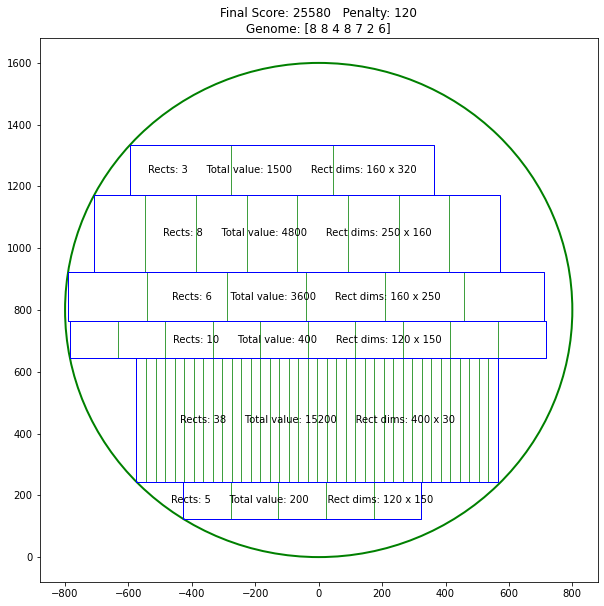

In [17]:
genome = population[0]
def plot_genome(genome, matrix, radius):
#-------------------------
    diameter = 2 * radius

    widths = matrix[:,0][genome]
    heights = matrix[:,1][genome]
    values = matrix[:,2][genome]

    left_start = radius - np.sqrt(radius**2 - (heights[0]/2) ** 2)
    borders = np.zeros(len(genome)+1) + left_start
    borders[1:] += np.cumsum(widths) 

    def get_col_max_height(x):
        # x is a point on the diameter, sieczna, x=0 corresponds to the leftmost point of diameter
        if x < 2 * radius:
            return 2 * np.sqrt(radius**2 - (radius-x)**2)
        else:
            return 0

    get_col_max_height = np.vectorize(get_col_max_height)

    max_heights_per_point = get_col_max_height(borders)

    max_col_heights = np.minimum(max_heights_per_point[:-1],max_heights_per_point[1:])

    def get_rect_count_in_col(col_height, rect_height):
        return np.int64(np.floor(col_height / rect_height))

    rect_counts_per_col = get_rect_count_in_col(max_col_heights, heights)

    score = np.sum(rect_counts_per_col * values)
    score_penalty = np.sum(widths[rect_counts_per_col==0])
    final_score = score - score_penalty
    #-------------------------

    circle1 = plt.Circle((0,radius),radius, color='g',fill=False,linewidth=2)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.add_patch(circle1)
    ax.set_ylim([-radius*0.1, diameter*1.05])
    ax.set_xlim([-radius*1.1, radius*1.1])

    # draw the rectangles
    for i in range(len(genome)):
        if rect_counts_per_col[i] > 0:
            for j in range(rect_counts_per_col[i]):
                rect = plt.Rectangle((-max_col_heights[i]/2+j*heights[i],borders[i]), heights[i],widths[i], color='g', fill=False, alpha=0.5)
                ax.add_patch(rect)
            rect = plt.Rectangle((-max_col_heights[i]/2,borders[i]), rect_counts_per_col[i]*heights[i], widths[i], color='b',fill=False)
            ax.add_patch(rect)
            rx, ry = rect.get_xy()
            cx = rx + rect.get_width()/2.0
            cy = ry + rect.get_height()/2.0
            printed_text = f"Rects: {rect_counts_per_col[i]}      Total value: {values[i]*rect_counts_per_col[i]}"+\
                            f"      Rect dims: {widths[i]} x {heights[i]}" 
            ax.annotate(printed_text, (cx, cy), color='black', fontsize=10, ha='center', va='center')

    plt.title("Final Score: "+str(final_score)+"   Penalty: "+str(score_penalty)+"\nGenome: "+str(genome))
    plt.show()

plot_genome(population[0],matrix, radius)

### Mutation operator

Possible mutations:
- add a column of rectangles
- remove a column of rectangles
- change a column of rectangles 

Adding a column of rectangles:
- select a random place in the genome and add a rectangle ID to the list of IDs, not necessarily at the end,
- probability is higher if sum of column widths is much smaller than the circle diameter.

Removing a column of rectangles:
- select a random ID from the list of IDs (genome) and remove it,
- probability is higher if sum of column widths is greater than the circle diameter.

Changing a column of rectangles:
- select a random ID from the list of IDs (genome) and swap it with a randomly chosen ID.

In [18]:
def add_rectangle(genome,matrix):
    random_position = random.randint(0, len(genome))
    new_rect_id = random.randint(0, len(matrix)-1)
    genome = np.insert(genome, random_position, new_rect_id)
    return genome

In [19]:
print(genome)
print(add_rectangle(genome, matrix))

[8 8 4 8 7 2 6]
[8 8 4 8 7 2 1 6]


In [20]:
def remove_rectangle(genome):
    random_position = random.randint(0, len(genome)-1)
    genome = np.delete(genome, random_position)
    return genome

In [22]:
print(genome)
print(remove_rectangle(genome))

[8 8 4 8 7 2 6]
[8 4 8 7 2 6]


In [23]:
def change_rectangle(genome,matrix):
    random_position = random.randint(0, len(genome)-1)
    new_rect_id = random.randint(0, len(matrix)-1)
    genome[random_position] = new_rect_id
    return genome

In [24]:
print(genome)
print(change_rectangle(genome, matrix))

[8 8 4 8 7 2 6]
[8 8 4 7 7 2 6]


In [25]:
def mutate(genome,matrix,diameter):
    genome_width = sum(matrix[:,0][genome])
    if genome_width == 0:
        return add_rectangle(genome, matrix)

    if genome_width < diameter:
        add_probability     = 0.6
        remove_probability  = 0.03
        change_probability = 0.6
    else:
        add_probability     = 0.03
        remove_probability  = 0.4
        change_probability = 0.6
    if random.random() < remove_probability:
        genome = remove_rectangle(genome)
    if random.random() < add_probability:
        genome = add_rectangle(genome, matrix)
    if random.random() < change_probability:
        genome = change_rectangle(genome, matrix)
    
    return genome

def mutate_population(population,matrix,diameter):
    return [mutate(genome, matrix, diameter) for genome in population]

### Crossover operator

Single point crossover.

In [26]:
import math

def crossover(p1, p2, matrix,diameter):
    split_point = random.randint(0, diameter)

    p1_chosen = matrix[:,0][p1].cumsum() < split_point
    p2_chosen = matrix[:,0][p2].cumsum() < split_point

    child1 = np.concatenate((p1[p1_chosen], p2[np.invert(p2_chosen)]))
    child2 = np.concatenate((p2[p2_chosen], p1[np.invert(p1_chosen)]))

    return child1, child2

def crossover_population(population, matrix, diameter):
    crossover_probability = 0.3
    selected_pairs_ids =  np.repeat(np.random.uniform(0,1,size=(math.floor(len(population)/2),1)) > crossover_probability,2)
    population_for_crossover = [population[:len(selected_pairs_ids)][i] for i in range(len(selected_pairs_ids)) if selected_pairs_ids[i]]
    j = 0
    for i in range(0,len(selected_pairs_ids),2):
        if selected_pairs_ids[i]:
            children = crossover(population_for_crossover[j],\
                                            population_for_crossover[j+1],\
                                            matrix,diameter)
            population[i] = children[0]
            population[i+1] = children[1]
            j += 1
    return population

In [32]:
print(population[0])
print(population[1])
print(crossover(population[0], population[1], matrix, diameter))

[8 8 0 7 8 2 6]
[3 6 9 4 7 7 4 9]
(array([8, 8, 0, 7, 8, 2, 6]), array([3, 6, 9, 4, 7, 7, 4, 9]))


### Tournament selection

In [33]:
def tournament(population,scores,tournament_size):
    selected = np.random.choice(population_size,size=population_size,replace=True)
    for i,selected_id in enumerate(selected):
        for new_id in np.random.choice(population_size,size=tournament_size,replace=True):
            if scores[selected_id] < scores[new_id]:
                selected[i] = new_id
    selected = selected.astype(np.int64)
    return list(itemgetter(*selected)(population))

In [35]:
scores = get_scores(population,matrix, radius)
tournament(population,scores,2) [ :10]

[array([7, 6, 1, 8, 7, 2, 8, 1, 8]),
 array([5, 6, 4, 6, 8, 6, 1]),
 array([1, 6, 4, 4, 2]),
 array([8, 4, 4, 6, 4, 0]),
 array([3, 6, 9, 0, 7, 8, 7, 2, 6]),
 array([1, 6, 4, 4, 2]),
 array([5, 6, 4, 6, 8, 6, 1]),
 array([5, 1, 8, 2, 7, 2, 5, 8]),
 array([8, 7, 6, 7, 4, 9, 9, 4]),
 array([9, 0, 3, 6, 3, 8, 2, 4, 9])]

## Whole algorithm

In [36]:
matrix = dfs[file_names[0]]
radius = int(file_names[0])

Epoch 0: 43830.0
Epoch 10: 50650.0
Epoch 20: 51080.0
Epoch 30: 50680.0
Epoch 40: 51240.0
Epoch 50: 51150.0
Epoch 60: 51750.0
Epoch 70: 51680.0
Epoch 80: 52750.0
Epoch 90: 52480.0
Best solution: [7 9 4 4 4 9 9 9 9 9 1 6 5]


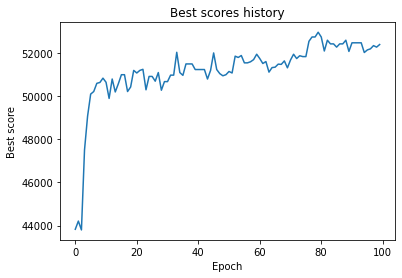

In [37]:
population_size = 100
tournament_size = 3
epochs = 100
dim=3

population = get_population(diameter, matrix, population_size)
best_solution, best_score = 0, get_scores(population[0].reshape((1,-1)),matrix, radius)[0]
best_scores_history = []
for epoch in range(epochs):
    population = crossover_population(population, matrix, diameter)
    population = mutate_population(population, matrix, diameter)
    scores = get_scores(population,matrix, radius)
    best_solution, best_score = population[np.argmax(scores)], np.max(scores)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: {best_score}")
    best_scores_history.append(best_score)
    population = tournament(population,scores,tournament_size)
print(f"Best solution: {best_solution}")
import matplotlib.pyplot as plt
plt.plot(best_scores_history)
plt.title("Best scores history")
plt.xlabel("Epoch")
plt.ylabel("Best score")
plt.show()

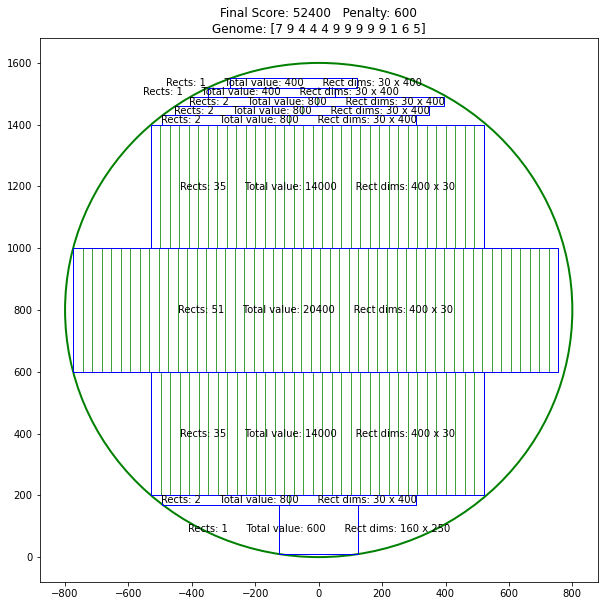

In [38]:
# plot best solution
plot_genome(best_solution, matrix, radius)